In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# —————— 1. データ読み込み & 前処理 ——————
train = pd.read_csv('../data/train.csv')

drop_cols = ['id', 'Podcast_Name', 'Episode_Title']
train = train.drop(columns=drop_cols)


# ① かける倍率を決めるマッピングを作成
sentiment_multiplier = {
    'Positive': 0.750,
    'Negative': 0.717,
    'Neutral': 1.000
}

# ① 感情順を定義
sentiment_order = ['Negative', 'Neutral', 'Positive']

# ② 感情ごとのListening_Time_minutesの平均を計算
mean_by_sentiment = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

# ③ Negativeの平均を取得
negative_mean = mean_by_sentiment['Negative']

# ④ Negativeとの差を取る
diff_from_negative = mean_by_sentiment - negative_mean

# ⑤ Negativeは0にする
diff_from_negative['Negative'] = 0.0

# ⑥ マッピング辞書作成
diff_map_sentiment = diff_from_negative.to_dict()


# ① Number_of_Adsが0〜3のデータだけに絞る
train_limited_ads = train[train['Number_of_Ads'].isin([0, 1, 2, 3])]

# ② Number_of_AdsごとにListening_Time_minutesの平均を計算
mean_by_ads = train_limited_ads.groupby('Number_of_Ads')['Listening_Time_minutes'].mean()

# ③ 小数第3位まで四捨五入
mean_by_ads = mean_by_ads.round(3)

# ④ 0.000〜3.000の0.001刻みのindexを作成
ads_range = np.arange(0.000, 3.001, 0.001)
ads_range = np.round(ads_range, 3)  # 小数第3位まで丸める

# ⑤ 元データに補完（interpolate）する
mean_by_ads_interp = mean_by_ads.reindex(ads_range).interpolate(method='linear')

# ① IQRで外れ値除去
Q1 = train['Episode_Length_minutes'].quantile(0.25)
Q3 = train['Episode_Length_minutes'].quantile(0.75)
IQR = Q3 - Q1

train_no_outliers = train[
    (train['Episode_Length_minutes'] >= Q1 - 1.5 * IQR) &
    (train['Episode_Length_minutes'] <= Q3 + 1.5 * IQR)
]

# ② ソートして最初9個・最後4個を除去
train_no_outliers = train_no_outliers.sort_values('Episode_Length_minutes')
train_no_outliers = train_no_outliers.iloc[9:-4]

# ③ 四捨五入してまとめる
train_no_outliers['Episode_Length_rounded'] = train_no_outliers['Episode_Length_minutes'].round()

# ④ クリーンなデータで四捨五入ごとにListening_Time_minutesの平均を取る
mean_by_episode_length = train_no_outliers.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# 曜日ごとの順番に合わせたエンコーディングマップを作成
day_order = {
    'Sunday': 0,
    'Thursday': 0.052308,
    'Friday': 0.389193,
    'Saturday': 0.509377,
    'Wednesday': 0.989779,
    'Monday': 1.152232,
    'Tuesday': 1.314013
}
# ① 感情順を定義
sentiment_order = ['Negative', 'Neutral', 'Positive']

# ② 感情ごとのListening_Time_minutesの平均を計算
mean_by_sentiment = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

# ③ Negativeの平均を取得
negative_mean = mean_by_sentiment['Negative']

# ④ Negativeとの差を取る
diff_from_negative = mean_by_sentiment - negative_mean

# ⑤ Negativeは0にする
diff_from_negative['Negative'] = 0.0

# ⑥ マッピング辞書作成
diff_map_sentiment = diff_from_negative.to_dict()





# ① 時間帯順を定義
time_order = ['Evening', 'Morning', 'Afternoon', 'Night']

# ② 時間帯ごとのListening_Time_minutesの平均を計算
mean_by_time = train.groupby('Publication_Time')['Listening_Time_minutes'].mean().reindex(time_order)

# ③ Eveningの平均を取得
evening_mean = mean_by_time['Evening']

# ④ Eveningとの差を取る
diff_from_evening = mean_by_time - evening_mean

# ⑤ Eveningは0にする
diff_from_evening['Evening'] = 0.0

# ⑥ マッピング辞書作成
diff_map_time = diff_from_evening.to_dict()


# trainに新しい特徴量を追加
train['Publication_Day_ordered'] = train['Publication_Day'].map(day_order)
# 2. 特徴量追加
train['Ads_Density'] = train['Episode_Length_minutes'] / (train['Number_of_Ads'] + 1)
# ⑤ trainデータ側にも同じように四捨五入列を作る
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()
# ⑥ クリーンなmean_by_episode_lengthをtrainにマッピングする
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_rounded'].map(mean_by_episode_length)
# ⑥ train側も小数第3位にそろえて準備
train['Number_of_Ads_rounded'] = np.round(train['Number_of_Ads'], 3)
# ⑦ mapを使ってinterpolateデータを特徴量として追加
train['Number_of_Ads_listen_mean_interp'] = train['Number_of_Ads_rounded'].map(mean_by_ads_interp)
# ⑦ 新しい特徴量作成（正しい固定値だけを持たせる）
train['Episode_Sentiment_diff_from_negative'] = train['Episode_Sentiment'].map(diff_map_sentiment)
# ⑦ 新しい特徴量作成
train['Publication_Time_diff_from_evening'] = train['Publication_Time'].map(diff_map_time)
train['Length_ratio'] = train['Episode_Length_minutes_group_mean'] / train['Episode_Length_rounded']

train['Episode_Length_minutes_scaled'] = train['Episode_Length_minutes'] * 0.728





# ① 最初の基準値（Number_of_Ads_listen_mean_interpの先頭の値）を取得
base_value = train['Number_of_Ads_listen_mean_interp'].iloc[0]


# ② 条件付きで差分を計算する特徴量を作成
train['Ads_listen_mean_diff_conditional'] = np.where(
    train['Number_of_Ads_rounded'].notnull(),  # Episode_Length_rounded が存在するなら
    train['Number_of_Ads_listen_mean_interp'] - base_value,  # 差分を取る
    0  # それ以外は0
)

# ① 丸める（たとえば四捨五入 or 小数第1位で切る）
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()

# ② groupbyで平均
mean_listen_by_rounded = train.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# ③ 0.728をかける
adjusted_mean_listen = mean_listen_by_rounded * 0.728

# ④ mapで特徴量を追加
train['Adjusted_Listening_by_Length'] = train['Episode_Length_rounded'].map(adjusted_mean_listen)

# ⑤Episode_Length_minutesとAdjusted_Listening_by_Lengthの両方で外れ値を除外
filtered_train = train[
    (train['Episode_Length_minutes'] >= 7) &  # 150分以下
    (train['Episode_Length_minutes'] <= 120) &  # 80分以下
    (train['Adjusted_Listening_by_Length'] >= 0) &  # 80分以下
    (train['Adjusted_Listening_by_Length'] <= 80)  # 80分以下
]

# ① 条件に合う行だけに True がつくマスクを作る
valid_mask = (
    (train['Episode_Length_minutes'] >= 10) &
    (train['Episode_Length_minutes'] <= 120) &
    (train['Adjusted_Listening_by_Length'] >= 0) &
    (train['Adjusted_Listening_by_Length'] <= 80)
)

# ② 最小値（validなデータだけで）
min_episode_length = train.loc[valid_mask, 'Episode_Length_minutes'].min()

# ③ 差分を作成、外れ値には NaN を入れる
train['Episode_Length_minutes_diff_from_min'] = np.where(
    valid_mask,
    train['Episode_Length_minutes'] - min_episode_length,
    np.nan  # 外れ値には NaN（または0でも可）
)


#Episode_Sentiment_diff_from_negativeの追加

# ① 感情順を定義
sentiment_order = ['Negative', 'Neutral', 'Positive']

# ② 感情ごとのListening_Time_minutesの平均を計算
mean_by_sentiment = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

# ③ Negativeの平均を取得
negative_mean = mean_by_sentiment['Negative']

# ④ Negativeとの差を取る
diff_from_negative = mean_by_sentiment - negative_mean

# ⑤ Negativeは0にする
diff_from_negative['Negative'] = 0.0

# ⑥ マッピング辞書作成
diff_map_sentiment = diff_from_negative.to_dict()
# ⑦ 新しい特徴量作成（正しい固定値だけを持たせる）
train['Episode_Sentiment_diff_from_negative'] = train['Episode_Sentiment'].map(diff_map_sentiment)

#Publication_Time_diff_from_eveningの追加
# ① 時間帯順を定義
time_order = ['Evening', 'Morning', 'Afternoon', 'Night']

# ② 時間帯ごとのListening_Time_minutesの平均を計算
mean_by_time = train.groupby('Publication_Time')['Listening_Time_minutes'].mean().reindex(time_order)

# ③ Eveningの平均を取得
evening_mean = mean_by_time['Evening']

# ④ Eveningとの差を取る
diff_from_evening = mean_by_time - evening_mean

# ⑤ Eveningは0にする
diff_from_evening['Evening'] = 0.0

# ⑥ マッピング辞書作成
diff_map_time = diff_from_evening.to_dict()
# ⑦ 新しい特徴量作成
train['Publication_Time_diff_from_evening'] = train['Publication_Time'].map(diff_map_time)

train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()
mean_by_length = train.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_rounded'].map(mean_by_length)

# 例えば新しく追加する別の特徴量も同様に
train['Host_to_Guest_popularity_ratio'] = train['Host_Popularity_percentage'] / (train['Guest_Popularity_percentage'] + 1)

# 3. 学習用行のフィルター条件だけ定義
mask = (
    (train['Episode_Length_rounded'] >= 7) &
    (train['Episode_Length_rounded'] <= 120)
)

# 4. 学習用 X, y を切り出す（ここでだけフィルターをかける）
feature_cols = [
    'Episode_Length_minutes_group_mean',
    'Episode_Length_rounded',
    'Publication_Time_diff_from_evening',
    'Episode_Sentiment_diff_from_negative',
    'Episode_Length_minutes',
    'Host_Popularity_percentage',
    'Guest_Popularity_percentage',
    'Number_of_Ads',
    'Publication_Day_ordered',
    'Ads_Density',
    'Number_of_Ads_rounded',
    'Number_of_Ads_listen_mean_interp',
    'Ads_listen_mean_diff_conditional',
]

X = train.loc[mask, feature_cols]
y = train.loc[mask, 'Listening_Time_minutes']

# train/valid に分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=50
)

# —————— 3. XGBoost 用 DMatrix を作成 ——————
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# —————— 4. ハイパラ設定 & 学習 ——————
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 1,
}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=10
)

# —————— 5. 評価 ——————
y_pred = bst.predict(dvalid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Validation RMSE: {rmse:.5f}')

[0]	train-rmse:20.44277	valid-rmse:20.38693
[1]	train-rmse:16.18816	valid-rmse:16.12758
[2]	train-rmse:13.61402	valid-rmse:13.55490
[3]	train-rmse:12.14782	valid-rmse:12.08723
[4]	train-rmse:11.35391	valid-rmse:11.29601
[5]	train-rmse:10.93685	valid-rmse:10.88254
[6]	train-rmse:10.72250	valid-rmse:10.67142
[7]	train-rmse:10.61147	valid-rmse:10.56323
[8]	train-rmse:10.55289	valid-rmse:10.50764
[9]	train-rmse:10.51995	valid-rmse:10.47716
[10]	train-rmse:10.50073	valid-rmse:10.45945
[11]	train-rmse:10.48902	valid-rmse:10.45019
[12]	train-rmse:10.47932	valid-rmse:10.44217
[13]	train-rmse:10.47249	valid-rmse:10.43626
[14]	train-rmse:10.46612	valid-rmse:10.43171
[15]	train-rmse:10.45811	valid-rmse:10.42718
[16]	train-rmse:10.45029	valid-rmse:10.42142
[17]	train-rmse:10.44491	valid-rmse:10.41905
[18]	train-rmse:10.43868	valid-rmse:10.41688
[19]	train-rmse:10.43483	valid-rmse:10.41630
[20]	train-rmse:10.42795	valid-rmse:10.41290
[21]	train-rmse:10.42377	valid-rmse:10.41257
[22]	train-rmse:10.4

1回目:10.84368
2回目：10.85430
3回目:10.52681
4回目：10.34169


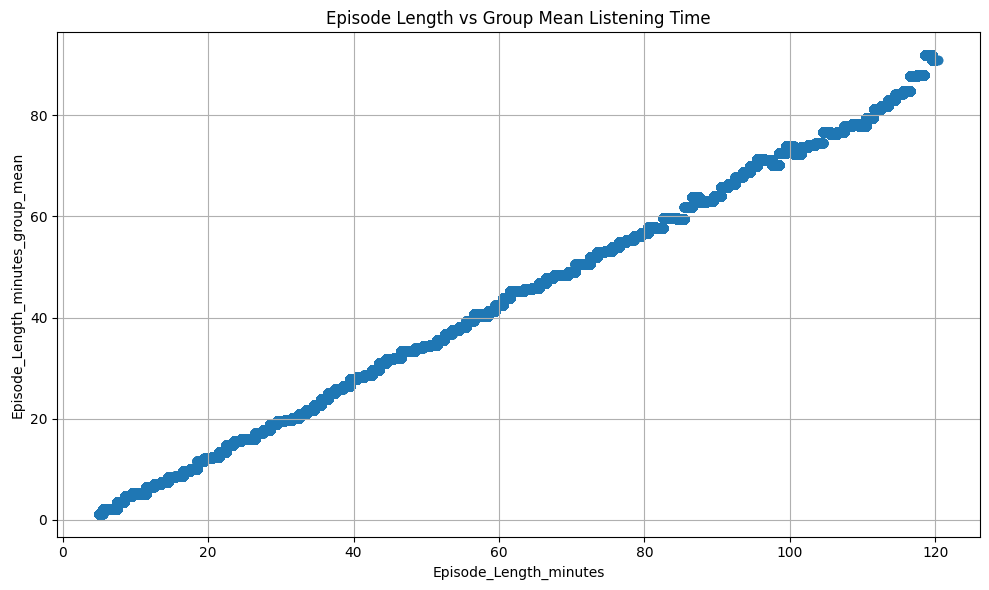

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み（必要なら）
train = pd.read_csv('../data/train.csv')


# ⑤ trainデータ側にも同じように四捨五入列を作る
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()

# ⑥ クリーンなmean_by_episode_lengthをtrainにマッピングする
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_rounded'].map(mean_by_episode_length)
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_minutes'].round().map(mean_by_episode_length)
# ⑥ train側も小数第3位にそろえて準備
# ⑦ グラフ作成（散布図）
plt.figure(figsize=(10, 6))
plt.scatter(train['Episode_Length_minutes'], train['Episode_Length_minutes_group_mean'], alpha=0.6)
plt.xlabel('Episode_Length_minutes')
plt.ylabel('Episode_Length_minutes_group_mean')
plt.title('Episode Length vs Group Mean Listening Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb

# —————— 1. 訓練データでグループ平均を計算 ——————
train = pd.read_csv('../data/train.csv')
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()
mean_by_length = train.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# —————— 2. 学習済みモデルを再学習（あるいはbstが既にメモリにある前提でもOK） ——————
# ここでは先ほどと同じように
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_rounded'].map(mean_by_length)
filtered = train[(train['Episode_Length_rounded'] >= 7) & (train['Episode_Length_rounded'] <= 120)].copy()

feature_cols = ['Episode_Length_minutes_group_mean', 'Episode_Length_rounded']
X = filtered[feature_cols]
y = filtered['Listening_Time_minutes']

dtrain = xgb.DMatrix(X, label=y)
params = {'objective':'reg:squarederror','eval_metric':'rmse','verbosity':0}
bst = xgb.train(params, dtrain, num_boost_round=bst.best_iteration if hasattr(bst,'best_iteration') else 100)

# —————— 3. テストデータの前処理と特徴量追加 ——————
test = pd.read_csv('../data/test.csv')
# 丸め
test['Episode_Length_rounded'] = test['Episode_Length_minutes'].round()
# グループ平均マッピング（train で計算した mean_by_length を使う）
test['Episode_Length_minutes_group_mean'] = test['Episode_Length_rounded'].map(mean_by_length)
# 万一 map で欠損する場合は 0.728×長さ で補完
test['Episode_Length_minutes_group_mean'] = test['Episode_Length_minutes_group_mean'].fillna(test['Episode_Length_minutes'] * 0.728)

# —————— 4. 予測 ——————
dtest = xgb.DMatrix(test[feature_cols])
test['Listening_Time_minutes'] = bst.predict(dtest)
